In [22]:
import jax
import numpyro
import numpy as np
import matplotlib.pyplot as plt
import numpyro_ext
import numpyro.distributions as dist
import numpyro_ext.distributions as distx, numpyro_ext.optim as optimx
import arviz as az
import corner
import itertools
import scipy
import jax.numpy as jnp
import pandas as pd 
from jaxoplanet.orbits.keplerian import Central
from jaxoplanet.starry.surface import Surface
from jaxoplanet.starry.orbit import SurfaceSystem
import astropy.constants as const

from collections.abc import Callable
from functools import partial
from jaxoplanet.starry.orbit import SurfaceSystem
from jaxoplanet.orbits.keplerian import Central, Body
from jaxoplanet.types import Array, Scalar
from jaxoplanet.core.limb_dark import light_curve as _limb_dark_light_curve
from jaxoplanet.starry.core.basis import A1, A2_inv, U
from jaxoplanet.starry.core.polynomials import Pijk
from jaxoplanet.starry.core.rotation import left_project
from jaxoplanet.starry.core.solution import rT, solution_vector
from jaxoplanet.starry.surface import Surface 

# For multi-core parallelism (useful when running multiple MCMC chains in parallel)
numpyro.set_host_device_count(2)

# For CPU (use "gpu" for GPU)
numpyro.set_platform("cpu")

# For 64-bit precision since JAX defaults to 32-bit
jax.config.update("jax_enable_x64", True)

h = 6.62607015e-34  # Planck constant [J*s]
c = 2.99792458e8    # speed of light [m/s]
kB = 1.380649e-23   # Boltzmann constant [J/K]

In [2]:
def planck(lamb_m, T):
    """Planck function B_lambda in SI units."""
    a = 2*h*c**2 / (lamb_m**5)
    b = h*c / (lamb_m*kB*T)
    return a / (jnp.exp(b) - 1)

def surface_light_curve(
    surface: Surface,
    r: float | None = None,
    x: float | None = None,
    y: float | None = None,
    z: float | None = None,
    theta: float | None = None,
    order: int = 20,
    higher_precision: bool = False,
):
    """Light curve of an occulted surface.

    Args:
        surface (Surface): Surface object
        r (float or None): radius of the occulting body, relative to the current map
           body
        x (float or None): x coordinate of the occulting body relative to the surface
           center. By default (None) 0.0
        y (float or None): y coordinate of the occulting body relative to the surface
           center. By default (None) 0.0
        z (float or None): z coordinate of the occulting body relative to the surface
           center. By default (None) 0.0
        theta (float):
            rotation angle of the map, in radians. By default 0.0
        order (int):
            order of the P integral numerical approximation. By default 20
        higher_precision (bool): whether to compute change of basis matrix as hight
            precision. By default False (only used to testing).

    Returns:
        ArrayLike: flux
    """
    if higher_precision:
        try:
            from jaxoplanet.starry.multiprecision import (
                basis as basis_mp,
                utils as utils_mp,
            )
        except ImportError as e:
            raise ImportError(
                "The `mpmath` Python package is required for higher_precision=True."
            ) from e

    total_deg = surface.deg

    rT_deg = rT(total_deg)

    x = 0.0 if x is None else x
    y = 0.0 if y is None else y
    z = 0.0 if z is None else z

    # no occulting body
    if r is None:
        b_rot = True
        theta_z = 0.0
        design_matrix_p = rT_deg

    # occulting body
    else:
        b = jnp.sqrt(jnp.square(x) + jnp.square(y))
        b_rot = jnp.logical_or(jnp.greater_equal(b, 1.0 + r), jnp.less_equal(z, 0.0))
        b_occ = jnp.logical_not(b_rot)

        # trick to avoid nan `x=jnp.where...` grad caused by nan sT
        r = jnp.where(b_rot, 1.0, r)
        b = jnp.where(b_rot, 1.0, b)

        if surface.ydeg == 0:
            if surface.udeg == 0:
                ld_u = jnp.array([])
            else:
                ld_u = jnp.concatenate(
                    [jnp.atleast_1d(jnp.asarray(u_)) for u_ in surface.u], axis=0
                )

            lc_func = partial(_limb_dark_light_curve, ld_u, order=order)
            lc = lc_func(b, r)
            return surface.amplitude * (1.0 + jnp.where(b_occ, lc, 0))

        else:
            theta_z = jnp.arctan2(x, y)
            sT = solution_vector(total_deg, order=order)(b, r)

        if total_deg > 0:
            if higher_precision:
                A2 = np.atleast_2d(utils_mp.to_numpy(basis_mp.A2(total_deg)))
            else:
                A2 = scipy.sparse.linalg.inv(A2_inv(total_deg))
                A2 = jax.experimental.sparse.BCOO.from_scipy_sparse(A2)
        else:
            A2 = jnp.array([[1]])

        design_matrix_p = jnp.where(b_occ, sT @ A2, rT_deg)

    if surface.ydeg == 0:
        rotated_y = surface.y.todense()
    else:
        rotated_y = left_project(
            surface.ydeg,
            surface._inc,
            surface._obl,
            theta,
            theta_z,
            surface.y.todense(),
        )

    # limb darkening
    if surface.udeg == 0:
        p_u = Pijk.from_dense(jnp.array([1]))
    else:
        u = jnp.array([1, *surface.u])
        p_u = Pijk.from_dense(u @ U(surface.udeg), degree=surface.udeg)

    # surface map * limb darkening map
    if higher_precision:
        A1_val = np.atleast_2d(utils_mp.to_numpy(basis_mp.A1(surface.ydeg)))
    else:
        A1_val = jax.experimental.sparse.BCOO.from_scipy_sparse(A1(surface.ydeg))

    p_y = Pijk.from_dense(A1_val @ rotated_y, degree=surface.ydeg)
    p_yu = p_y * p_u
    norm = np.pi / (p_u.tosparse() @ rT(surface.udeg))

    return surface.amplitude * (p_yu.tosparse() @ design_matrix_p) * norm

def system_observable(surface_observable, flux_planet, flux_star, **kwargs):
    _surface_observable = partial(surface_observable, **kwargs)

    def observable_fun(
        system: SurfaceSystem,
    ) -> Callable[[Scalar], tuple[Array | None, Array | None]]:
        # the observable function of the central given the position and radii
        # of all other bodies
        central_bodies_observable = jax.vmap(
            _surface_observable, in_axes=(None, 0, 0, 0, 0, None)
        )

        # the observable function of all bodies combined given their position to the
        # central
        @partial(system.surface_vmap, in_axes=(0, 0, 0, 0, None))
        def compute_body_observable(surface, radius, x, y, z, time):
            if surface is None:
                return 0.0
            else:
                theta = surface.rotational_phase(time)
                return _surface_observable(
                    surface,
                    (system.central.radius / radius),
                    (x / radius),
                    (y / radius),
                    (z / radius),
                    theta,
                )

        @partial(jnp.vectorize, signature="()->(n)")
        def observable_impl(time: Scalar) -> Array:
            # a function that give the array of observables for all bodies, starting
            # with the central
            if system.central_surface is None:
                central_light_curves = jnp.array([0.0])
            else:
                theta = system.central_surface.rotational_phase(time)
                central_radius = system.central.radius
                central_phase_curve = _surface_observable(
                    system.central_surface, theta=theta
                )
                if len(system.bodies) > 0:
                    xos, yos, zos = system.relative_position(time)
                    n = len(xos)
                    central_light_curves = central_bodies_observable(
                        system.central_surface,
                        (system.radius / central_radius),
                        (xos / central_radius),
                        (yos / central_radius),
                        (zos / central_radius),
                        theta,
                    )
                    def phase_planet(time,P,t0=0):
                        phase = jnp.sin(((time+t0)/P)*2*jnp.pi - jnp.pi/2)/2+0.5 
                        return phase
                    if n > 1 and central_light_curves is not None:
                        central_light_curves = central_light_curves.sum(
                            0
                        ) - central_phase_curve * (n - 1)
                        central_light_curves = jnp.expand_dims(central_light_curves, 0)

                    body_light_curves = compute_body_observable(
                        system.radius, -xos, -yos, -zos, time
                    )
                    in_eclipse = jnp.logical_not(body_light_curves)
                    body_light_curves_2 = (flux_planet/flux_star)*phase_planet(time,system.bodies[0].period)*(system.bodies[0].radius/system.central.radius)**2 * (-1*in_eclipse+1) 
                    #body_light_curves_2 = body_light_curves_2/jnp.max(body_light_curves_2)
                    return jnp.hstack([central_light_curves, body_light_curves_2])
                else:
                    return jnp.array([central_phase_curve])

        return observable_impl

    return observable_fun

def light_curve(system, flux_planet, flux_star, order=20):
    return system_observable(surface_light_curve, flux_planet, flux_star, order=order)(system)

In [3]:
def fast_binning(x, y, bins, error=None, std=False):
    bins = np.arange(np.min(x), np.max(x), bins)
    d = np.digitize(x, bins)

    n = np.max(d) + 2

    binned_x = np.empty(n)
    binned_y = np.empty(n)
    binned_error = np.empty(n)

    binned_x[:] = -np.pi
    binned_y[:] = -np.pi
    binned_error[:] = -np.pi

    for i in range(0, n):
        s = np.where(d == i)
        if len(s[0]) > 0:
            s = s[0]
            binned_y[i] = np.mean(y[s])
            binned_x[i] = np.mean(x[s])
            binned_error[i] = np.std(y[s]) / np.sqrt(len(s))

            if error is not None:
                err = error[s]
                binned_error[i] = np.sqrt(np.sum(np.power(err, 2))) / len(err)
            else:
                binned_error[i] = np.std(y[s]) / np.sqrt(len(s))

    nans = binned_x == -np.pi
    
    return binned_x[~nans], binned_y[~nans], binned_error[~nans]

0.0120015
1031.2476166730817


/tmp/ipykernel_360494/3159290151.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


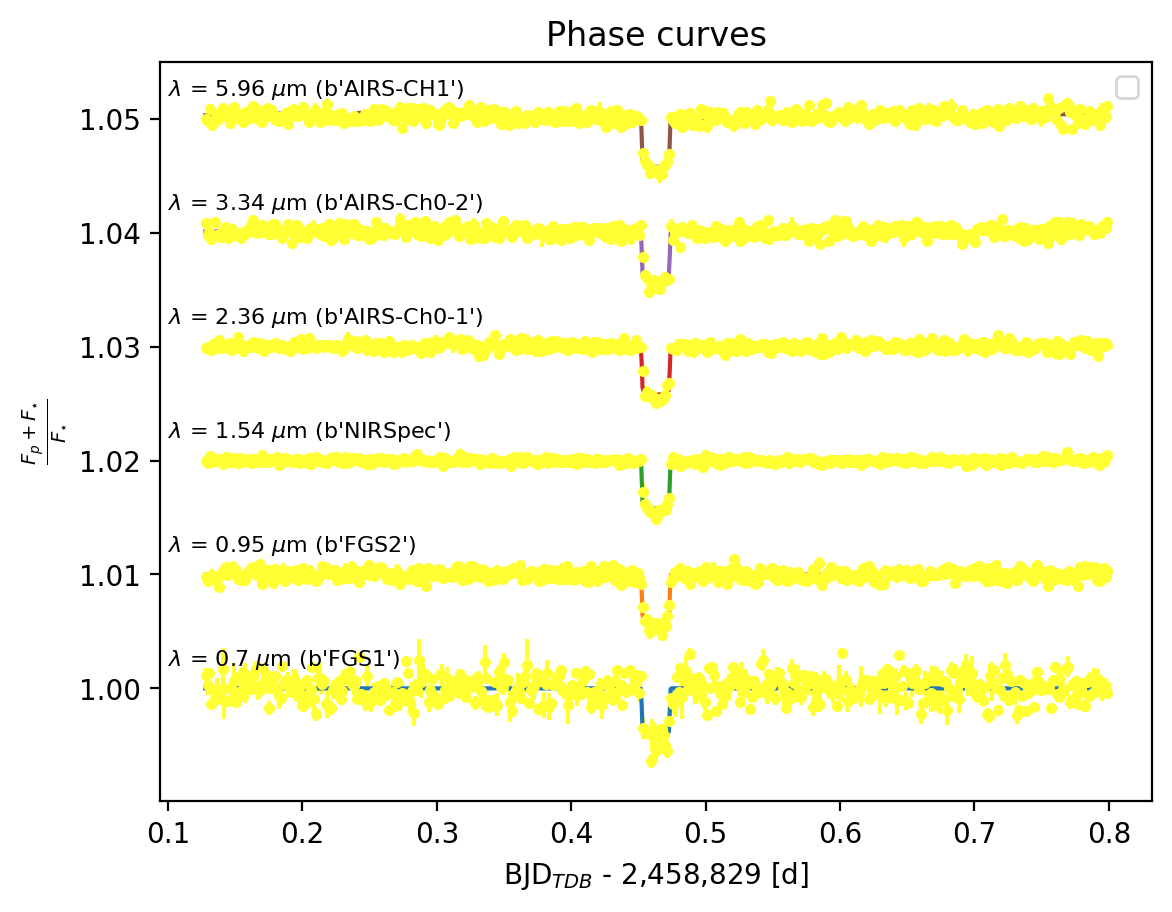

In [4]:
df = pd.read_pickle("LHS3844b_0.0_1obs.pickle")
wvl = df['data'].keys()

df2 = pd.read_pickle("LHS3844b_phase_curve_max_1obs.pickle")
yerr = df2['datasets'][b'AIRS-Ch0-2']['lc']['flux_error'][0]

P=df2['theta'][3]
R_star = df2['theta'][0]
M_star = df2['theta'][2]
time_transit = 0
R = df2['theta'][6]*R_star
print(R)
T_star = df2['theta'][1]
T_planet = df2['theta'][8]
print(T_planet)
uu = np.array([0.1, 0.06]) # Quadratic limb-darkening coefficients

def light_curve_model(time, lamb, R, T_planet, T_star, P, R_star, M_star, time_transit, uu): # light_curve_model(time, time_transit, P, R_star, M_star, R, T_star, T_planet, uu)
    star = Central(radius=R_star, mass=M_star)
    planet = Body(radius=R, time_transit=time_transit, period=P)
    m = Surface(u=uu)
    system = SurfaceSystem(star, m).add_body(planet, m)
    flux_star = planck(lamb*1e-6, jnp.mean(T_star))
    flux_planet = planck(lamb*1e-6, jnp.mean(T_planet))
    pc = light_curve(system, flux_planet, flux_star)(time)[:,1] + light_curve(system, flux_planet, flux_star)(time)[:,0]
    #pc = pc/np.max(pc)
    return pc

instru = df2['datasets'].keys()
instru = list(instru)
instru.pop(0)

fig, ax = plt.subplots(dpi=200)
offset = 0.0
for i, inst in enumerate(instru) : 
    time = df2['datasets'][inst]['lc']['time'] - 2458828.93
    pc = df2['datasets'][inst]['lc']['model']
    second_binned = fast_binning(time, df2['datasets'][inst]['lc']['ariel'], 2/(60*24))
    ax.errorbar(second_binned[0], second_binned[1] + offset, yerr=second_binned[2], c=(1, 1, 0.2), fmt='.')
    ax.plot(time, light_curve_model(time, list(wvl)[i], R, T_planet, T_star, P, R_star, M_star, time_transit, uu) + offset)
    ax.annotate(rf'$\lambda$ = {list(wvl)[i]} $\mu$m ({str(inst)})', xy=(0.1, 1.002 + offset), fontsize=8)
    offset += 0.01
plt.title(rf'Phase curves')
plt.legend()
plt.xlabel(r'BJD$_{TDB}$ - 2,458,829 [d]')
plt.ylabel(r'$\frac{F_p + F_{\star}}{F_{\star}}$')
plt.show()

In [8]:
def mcmc(binned, lamb, P, R_star, M_star, time_transit, R_planet, T_star, T_planet, uu):
        time = binned[0]
        observed = binned[1]
        yerr_array = binned[2]
        yerr = binned[2][0]
        def MCMC_model(time, yerr, y=None):
            # Priors for the parameters we're fitting for

            # The radius of the planet
            r = numpyro.sample("r", numpyro.distributions.Normal(R_planet, 0.01))

            # The star temperature
            T_star_prior = numpyro.sample("T_star", numpyro.distributions.Normal(T_star, 10))

            # The planet temperature
            T_planet_prior = numpyro.sample("T_planet", numpyro.distributions.Normal(T_planet, 200))

            # The orbit and light curve
            y_pred = light_curve_model(time, lamb, r, T_planet_prior, T_star_prior, P, R_star, M_star, time_transit, uu)

            # Let's track the light curve
            numpyro.deterministic("light_curve", y_pred)

            # The likelihood function assuming Gaussian uncertainty
            numpyro.sample("obs", numpyro.distributions.Normal(y_pred, yerr), obs=y)

        n_prior_samples = 3000
        prior_samples = numpyro.infer.Predictive(MCMC_model, num_samples=n_prior_samples)(
            jax.random.PRNGKey(0), time, yerr
        )

        # Let's make it into an arviz InferenceData object.
        # To do so we'll first need to reshape the samples to be of shape (chains, draws, *shape)
        converted_prior_samples = {
            f"{p}": np.expand_dims(prior_samples[p], axis=0) for p in prior_samples
        }
        prior_samples_inf_data = az.from_dict(converted_prior_samples)
        """fig = plt.figure(figsize=(12, 12))
        _ = corner.corner(
            prior_samples_inf_data,
            fig=fig,
            var_names=["r", "T_planet", "T_star"],
            truths=[R_planet, T_planet, T_star],
            show_titles=True,
            title_kwargs={"fontsize": 10},
            label_kwargs={"fontsize": 10},
        )"""
        init_param_method = "true_values"  # "prior_median" or "true_values"

        if init_param_method == "prior_median":
            print("Starting from the prior medians")
            run_optim = numpyro_ext.optim.optimize(
                MCMC_model, init_strategy=numpyro.infer.init_to_median()
            )
        elif init_param_method == "true_values":
            print("Starting from the true values")
            init_params = {
                #"t0": float(time_transit),
                #"logP": jnp.log(P),
                "r": R_planet,
                #"logM": jnp.log(M_star),
                "T_star" : float(T_star),
                "T_planet" : float(T_planet),
                #"u": uu,
            }
            run_optim = numpyro_ext.optim.optimize(
                MCMC_model,
                init_strategy=numpyro.infer.init_to_value(values=init_params),
            )

        time = jnp.asarray(time, dtype=jnp.float64)
        yerr = jnp.asarray(yerr, dtype=jnp.float64)
        observed = jnp.asarray(observed, dtype=jnp.float64)

        opt_params = run_optim(jax.random.PRNGKey(3), time, yerr, y=observed)
        for k, v in opt_params.items():
            if k in ["light_curve", "obs"]:
                continue
            print(f"optimized value of {k}: {v}")
        sampler = numpyro.infer.MCMC(
        numpyro.infer.NUTS(
            MCMC_model,
            dense_mass=True,
            regularize_mass_matrix=True,
            init_strategy=numpyro.infer.init_to_value(values=opt_params),
        ),
        num_warmup=500,
        num_samples=1000,
        num_chains=1,
        progress_bar=True,
        )

        sampler.run(jax.random.PRNGKey(1), time, yerr, y=observed)
        samples = sampler.get_samples()
        r_percentiles = np.percentile(samples["r"], [16, 50, 84], axis=0)
        r_minus = r_percentiles[1]-r_percentiles[0]
        r_plus = r_percentiles[2]-r_percentiles[1]
        R_mcmc = r_percentiles[1]
        T_percentiles = np.percentile(samples["T_planet"], [16, 50, 84], axis=0)
        T_minus = T_percentiles[1]-T_percentiles[0]
        T_plus = T_percentiles[2]-T_percentiles[1]
        T_mcmc = T_percentiles[1]
        T_star_mcmc = np.median(samples["T_star"])

        plt.figure()
        plt.plot(time, light_curve_model(time, lamb, R_planet, T_planet, T_star, P, R_star, M_star, time_transit, uu), label='truth', zorder=3)
        plt.plot(time, light_curve_model(time, lamb, R_mcmc, T_mcmc, T_star_mcmc, P, R_star, M_star, time_transit, uu), "--C0", label="MCMC result", zorder=3)
        plt.errorbar(time, observed, yerr=yerr_array, fmt='o', label='observed binned')
        plt.title(rf'Phase curve at $\lambda$ = {lamb} $\mu$m')
        plt.legend()
        plt.xlabel(r'BJD$_{TDB}$ - 2,458,829 [d]')
        plt.ylabel(r'$\frac{F_p + F_{\star}}{F_{\star}}$')
        plt.show()
        return {"R" : (r_minus, r_plus, R_mcmc), "T_planet" : (T_minus, T_plus, T_mcmc)}

Starting from the true values
optimized value of r: 0.012294423816675667
optimized value of T_star: 3035.999999986585
optimized value of T_planet: 1031.2476167897905


sample: 100%|██████████| 1500/1500 [02:50<00:00,  8.81it/s, 15 steps of size 7.91e-02. acc. prob=0.93] 


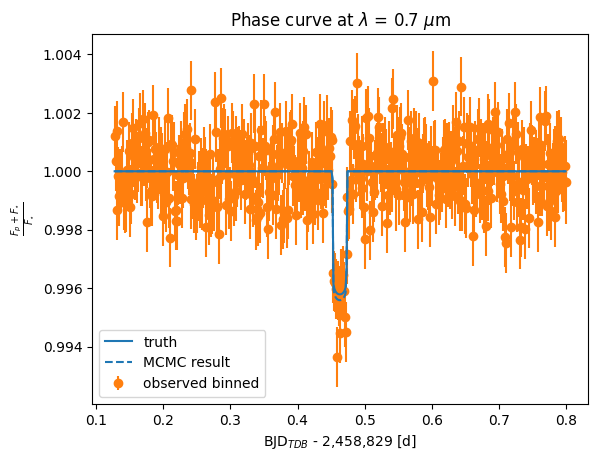

Starting from the true values
optimized value of r: 0.012292728965080865
optimized value of T_star: 3035.999720325786
optimized value of T_planet: 1032.199995611064


sample: 100%|██████████| 1500/1500 [05:33<00:00,  4.49it/s, 3 steps of size 2.64e-02. acc. prob=0.94]  


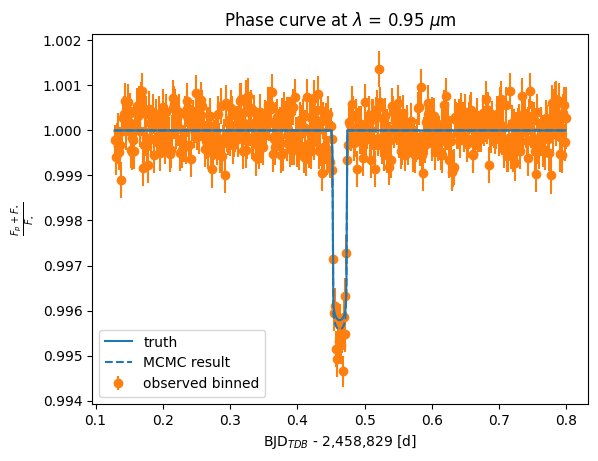

Starting from the true values
optimized value of r: 0.012167387755715171
optimized value of T_star: 3035.975696157555
optimized value of T_planet: 1101.6870983910906


sample: 100%|██████████| 1500/1500 [07:32<00:00,  3.32it/s, 3 steps of size 1.34e-02. acc. prob=0.94]  


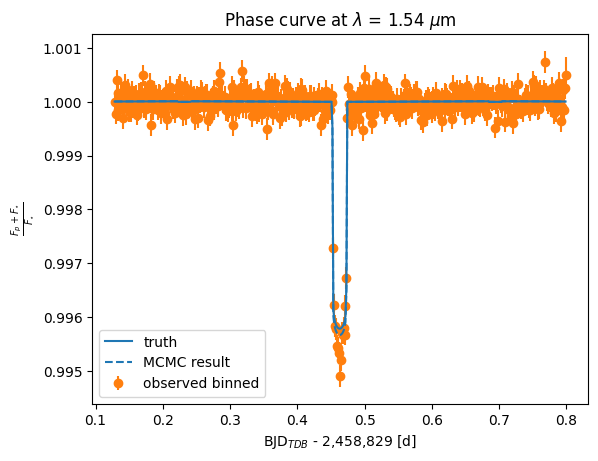

Starting from the true values
optimized value of r: 0.012122490839409202
optimized value of T_star: 3035.9910679959953
optimized value of T_planet: 1056.8531201796598


sample: 100%|██████████| 1500/1500 [05:20<00:00,  4.68it/s, 3 steps of size 2.43e-02. acc. prob=0.93]  


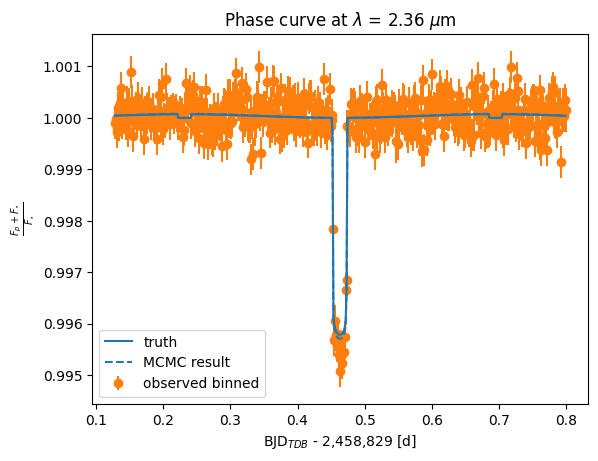

Starting from the true values
optimized value of r: 0.012237618598180533
optimized value of T_star: 3036.0023788821977
optimized value of T_planet: 1024.821406504694


sample: 100%|██████████| 1500/1500 [04:20<00:00,  5.77it/s, 3 steps of size 3.25e-02. acc. prob=0.93]  


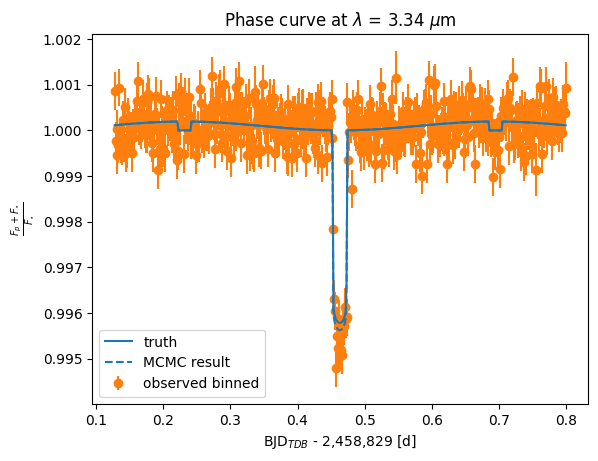

Starting from the true values
optimized value of r: 0.012183677999933381
optimized value of T_star: 3036.0323629569425
optimized value of T_planet: 952.9664129861883


sample: 100%|██████████| 1500/1500 [04:40<00:00,  5.35it/s, 63 steps of size 2.85e-02. acc. prob=0.92] 


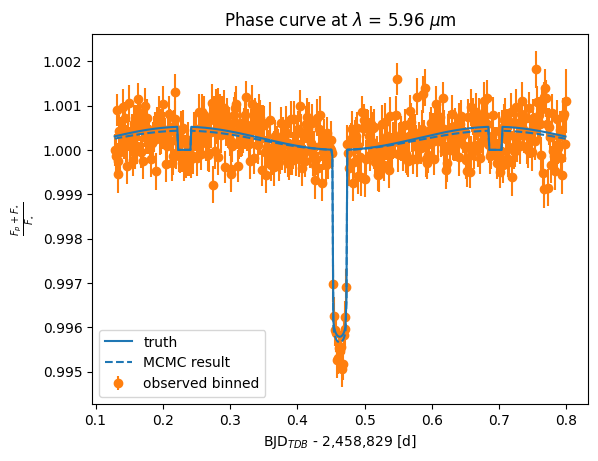

In [10]:
radii = []
radii_plus = []
radii_minus = []
Temps = []
Temps_plus = []
Temps_minus = []
for i, inst in enumerate(instru) : 
    time = df2['datasets'][inst]['lc']['time'] - 2458828.93
    pc = df2['datasets'][inst]['lc']['model']
    binned = fast_binning(time, df2['datasets'][inst]['lc']['ariel'], 2/(60*24), error=np.array(df2['datasets'][inst]['lc']['flux_error']))
    data = mcmc(binned, list(wvl)[i], P, R_star, M_star, time_transit, R, T_star, T_planet, uu)
    radii_minus.append(data["R"][0])
    radii_plus.append(data["R"][1])
    radii.append(data["R"][2])
    Temps_minus.append(data["T_planet"][0])
    Temps_plus.append(data["T_planet"][1])
    Temps.append(data["T_planet"][2])

In [20]:
print(radii)
print(radii_minus)
print(Temps)

[np.float64(0.01228137799154337), np.float64(0.01229139792134585), np.float64(0.012168213726091889), np.float64(0.012114836109223173), np.float64(0.012225630282078476), np.float64(0.012180207517954487)]
[np.float64(0.0003907033557701608), np.float64(0.00012383477516753234), np.float64(6.805465615742148e-05), np.float64(0.00011146057158575688), np.float64(0.00015305939773284892), np.float64(0.00013333640722631296)]
[np.float64(1017.1818533595331), np.float64(1041.9626727691052), np.float64(1050.3460899169181), np.float64(1047.7589812953738), np.float64(1020.4852963794361), np.float64(951.762697469567)]


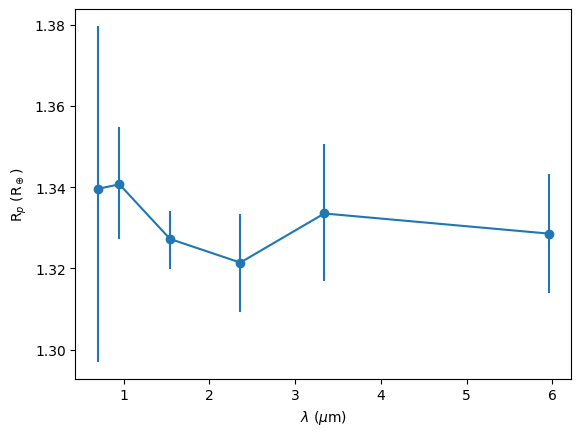

In [25]:
r_yerr = np.vstack((radii_minus, radii_plus))

plt.figure()
plt.errorbar(wvl, radii*const.R_sun/const.R_earth, r_yerr*const.R_sun/const.R_earth, fmt='-o')
plt.xlabel(r'$\lambda$ ($\mu$m)')
plt.ylabel(r'R$_p$ (R$_\oplus$)')
plt.show()

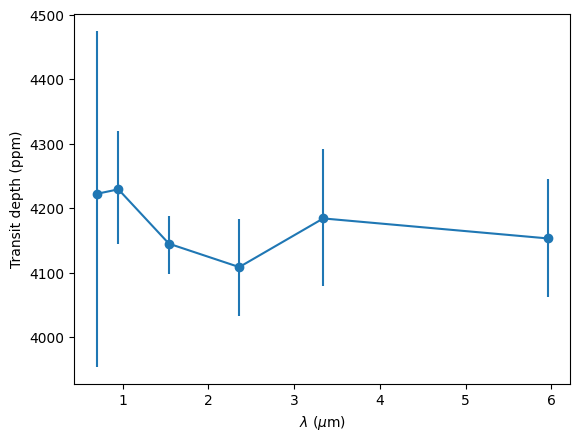

In [26]:
transit_depth = (np.array(radii)/R_star)**2
transit_depth_plus = 2*np.array(radii)*np.array(radii_plus)/(R_star)**2
transit_depth_minus = 2*np.array(radii)*np.array(radii_minus)/(R_star)**2

transit_yerr = np.vstack((transit_depth_minus, transit_depth_plus))

plt.figure()
plt.errorbar(wvl, transit_depth*1e6, transit_yerr*1e6, fmt='-o')
plt.xlabel(r'$\lambda$ ($\mu$m)')
plt.ylabel(r'Transit depth (ppm)')
plt.show()

[np.float64(2.4191783724596025e-08), np.float64(8.423658652901204e-07), np.float64(1.2292562108478792e-05), np.float64(2.3214454178027772e-05), np.float64(2.785627448980498e-05), np.float64(2.6984695833801163e-05)]
[np.float64(2.48207493050229e-08), np.float64(8.052652476609996e-07), np.float64(9.460601708272958e-06), np.float64(1.891966146252845e-05), np.float64(2.8732618249219742e-05), np.float64(2.8052061394857617e-05)]
[np.float64(4664111.222177773), np.float64(210388392.46306112), np.float64(1969894243.7589865), np.float64(1422565937.244185), np.float64(599534703.309695), np.float64(79294208.37990022)]
[np.float64(4785474.316481896), np.float64(201121065.55705467), np.float64(1516029712.5694976), np.float64(1158296556.499072), np.float64(618559733.9334055), np.float64(82758459.32412866)]


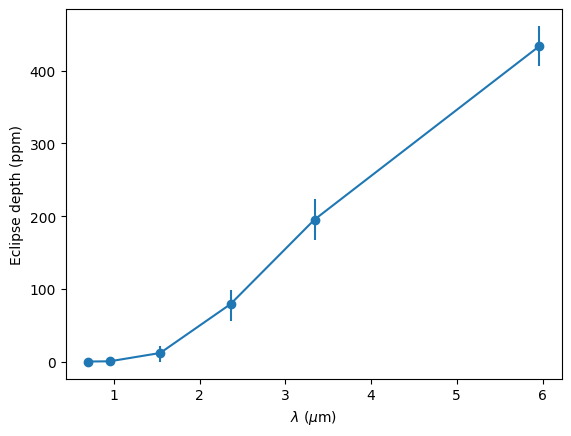

In [21]:
planet_fluxes = []
planet_fluxes_plus = []
planet_fluxes_minus = []
star_fluxes = []
eclipse_depths = []
eclipse_depths_plus = []
eclipse_depths_minus = []

def dB_dT(lam, T):
    x = h*c/(lam*kB*T)
    return (2*h*c**2/lam**5) * (x*np.exp(x)) / (T*(np.exp(x)-1)**2)

for i in range(len(wvl)):
    planet_fluxes.append(planck(list(wvl)[i]*1e-6, Temps[i]))
    planet_fluxes_minus.append(dB_dT(list(wvl)[i]*1e-6, Temps[i])*Temps_minus[i])
    planet_fluxes_plus.append(dB_dT(list(wvl)[i]*1e-6, Temps[i])*Temps_plus[i])
    star_fluxes.append(planck(list(wvl)[i]*1e-6, T_star))
for i in range(len(wvl)):
    eclipse_depths.append((planet_fluxes[i]/star_fluxes[i])*(radii[i]/R_star)**2)
    cst = 1/(star_fluxes[i]*R_star**2)
    eclipse_depths_minus.append(np.sqrt((cst*(radii[i]**2)*planet_fluxes_minus[i])**2 + (2*cst*planet_fluxes[i]*radii[i]*radii_minus[i])**2))
    eclipse_depths_plus.append(np.sqrt((cst*(radii[i]**2)*planet_fluxes_plus[i])**2 + (2*cst*planet_fluxes[i]*radii[i]*radii_plus[i])**2))

print(eclipse_depths_minus)
print(eclipse_depths_plus)
print(planet_fluxes_minus)
print(planet_fluxes_plus)
depth_yerr = np.vstack((eclipse_depths_minus, eclipse_depths_plus))

plt.figure()
plt.errorbar(wvl, np.array(eclipse_depths)*1e6, np.array(depth_yerr)*1e6, fmt='-o')
plt.xlabel(r'$\lambda$ ($\mu$m)')
plt.ylabel(r'Eclipse depth (ppm)')
plt.show()